# Imports

In [ ]:
from os import listdir,path
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten,BatchNormalization,Activation,Dropout,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from scipy.stats import reciprocal
import matplotlib.pyplot as plt
from tensorflow.keras.models import clone_model
from tensorflow.keras import Model
from tensorflow.keras.applications import inception_v3,resnet50,xception,inception_resnet_v2 
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

# Load the data

In [2]:
img_width = 150
img_height = 150
batch_size = 32
directory = '../input/microsoft-catsvsdogs-dataset/PetImages'
def make_df(directory):
    labels = listdir(directory)
    picture_paths = []
    picture_labels = []
    for label in labels:
        label_folder_path = path.join(directory,label)
        pictures = listdir(label_folder_path)
        picture_paths += [path.join(label_folder_path,file) for file in pictures]
        picture_labels += [label] * len(pictures)
    df = pd.DataFrame({"filename": picture_paths,"class": picture_labels})
    df = df.drop([3389,8246,20747,22300]) # invalid indexes
    return df

def split_df(full_df,train_size = 200,test_size = "",validation_size=0.1):
    train_inds = np.random.randint(0,len(full_df),size = train_size)
    non_train_inds = np.array(list((set(range(0,len(full_df))) - set(train_inds))))
    if isinstance(test_size,str):
        test_inds = non_train_inds
    else:
        test_inds = np.random.choice(non_train_inds, size = test_size)
    valid_ids = np.random.choice(train_inds,size = int(train_size*validation_size))
    train_df = full_df.iloc[list(set(train_inds) - set(valid_ids))]
    valid_df = full_df.iloc[valid_ids]
    test_df = full_df.iloc[test_inds]
    return train_df, valid_df, test_df

# Generators setup

In [3]:
def train_val_test_generator(directory,train_size = 200,test_size = "",validation_size=0.2, preprocessing_function=None,
                            batch_size=32):
    full_df = make_df(directory)
    train_df, valid_df, test_df = split_df(full_df,train_size,test_size,validation_size)
    
    train_gen = ImageDataGenerator(rotation_range=10,width_shift_range=10,height_shift_range=10,brightness_range=(0.8,1.2),
            shear_range=0.2,zoom_range=0.2,channel_shift_range=10,horizontal_flip=True,rescale = 1/255,
                                   validation_split=0,preprocessing_function=preprocessing_function)
    test_gen = ImageDataGenerator(vertical_flip=True,validation_split=0,rescale = 1/255,preprocessing_function=preprocessing_function)
    
    
    train_flow = train_gen.flow_from_dataframe(train_df,x_col='filename',y_col='class',target_size=(150, 150),class_mode = 'binary',
                        batch_size=batch_size,shuffle=True,seed=42,save_format='jpg',validate_filenames=False)
    valid_flow = test_gen.flow_from_dataframe(valid_df,x_col='filename',y_col='class',target_size=(150, 150),class_mode = 'binary',
                        batch_size=batch_size,seed=42,save_format='jpg',validate_filenames=False,shuffle = False)
    test_flow = test_gen.flow_from_dataframe(test_df,x_col='filename',y_col='class',target_size=(150, 150),class_mode = 'binary',
                        batch_size=batch_size,seed=42,save_format='jpg',validate_filenames=False,shuffle = False)
    return train_flow,valid_flow,test_flow

# Model set up

In [4]:
def plot_loss(history,max_y = 0,title = ""):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    if max_y != 0:
        plt.ylim((np.min(history.history['loss'])*0.75, max_y)) # scale control
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(title)
    plt.show()
    
def get_call_backs(model_name):
    chk_point = ModelCheckpoint(f'./best_model_{model_name}.h5',monitor = 'val_accuracy',mode = 'max',save_best_model = True,save_weights_only = True)
    early_stop = EarlyStopping(monitor="val_loss",patience=18,verbose=0,mode="min",restore_best_weights=True)
    reduce_le_plat = ReduceLROnPlateau(monitor="val_loss", factor = 0.5, patience = 5,verbose = 1)
    return [chk_point,early_stop,reduce_le_plat]

def make_model(base_model_func,denses = [256,128],learning_rate = 1e-3,pooling = "max"):
    base_model = base_model_func(weights="imagenet",include_top=False,input_shape = (150,150,3),pooling = pooling)
    for layer in base_model.layers:
        layer.trainable = False
    final_model = base_model.layers[-1].output
    final_model = Dropout(0.5)(final_model)
    for dense_layer in denses:
        final_model = Dense(dense_layer,kernel_initializer="he_normal")(final_model)
        final_model = BatchNormalization()(final_model)
        final_model = Dropout(0.3)(final_model)
        final_model = Activation("relu")(final_model)
    output = Dense(1, activation="sigmoid")(final_model)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(loss="binary_crossentropy",optimizer=Adam(learning_rate = learning_rate),metrics=["accuracy"])
    return model

def fit_model(model,directory,model_name,epochs = [10,100],learning_rate = 1e-3,
             train_size = 2000,test_size = "",validation_size=0.2, preprocessing_function=None,batch_size=32):
    train_flow,valid_flow,test_flow = train_val_test_generator(directory,train_size,test_size,
                                                               validation_size, preprocessing_function,batch_size)
    callbacks = get_call_backs(model_name)
    history_pre = model.fit(train_flow, epochs=epochs[0], validation_data=valid_flow,callbacks = callbacks,workers  = -1)
    plot_loss(history_pre,title = model_name)
    for layer in model.layers:
        layer.trainable = True
    model.compile(loss="binary_crossentropy",optimizer=Adam(learning_rate = learning_rate*1e-2),metrics=["accuracy"])
    history = model.fit(train_flow, epochs=epochs[1], validation_data=valid_flow,callbacks = callbacks,workers  = -1)
    plot_loss(history,title = model_name)
    return model,history_pre,history

# Model training

### training 4 different models to choose best one using transfer learning

In [5]:
models = {"xception": [xception.Xception,xception.preprocess_input],
         "inception_v3": [inception_v3.InceptionV3,inception_v3.preprocess_input],
         "resnet50": [resnet50.ResNet50,resnet50.preprocess_input],
         "inception_resnet_v2": [inception_resnet_v2.InceptionResNetV2,inception_resnet_v2.preprocess_input]}
def make_train_model(model_name,models=models,train_size = 2000,test_size = "",validation_size=0.2):
    model_parms = models[model_name]
    model = make_model(model_parms[0],learning_rate = 1e-4)
    model,history_pre,history = fit_model(model,directory,model_name,preprocessing_function = model_parms[1],
                                         train_size = train_size,test_size = test_size,validation_size=validation_size)
    return model,history_pre,history

2022-09-16 10:11:59.391153: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-16 10:11:59.500452: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-16 10:11:59.501531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-16 10:11:59.503807: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 2s 0us/step
Found 1562 non-validated image filenames belonging to 2 classes.
Found 400 non-validated image filenames belonging to 2 classes.
Found 23073 non-validated image filenames belonging to 2 classes.


2022-09-16 10:12:08.685321: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-09-16 10:12:12.806041: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


49/49 [==============================] - 44s 708ms/step - loss: 0.8119 - accuracy: 0.4942 - val_loss: 0.6929 - val_accuracy: 0.5275
Epoch 2/10
49/49 [==============================] - 19s 380ms/step - loss: 0.7774 - accuracy: 0.5275 - val_loss: 0.6923 - val_accuracy: 0.5275
Epoch 3/10
49/49 [==============================] - 18s 358ms/step - loss: 0.7914 - accuracy: 0.4853 - val_loss: 0.6921 - val_accuracy: 0.5400
Epoch 4/10
49/49 [==============================] - 18s 366ms/step - loss: 0.7770 - accuracy: 0.5070 - val_loss: 0.6920 - val_accuracy: 0.5400
Epoch 5/10
49/49 [==============================] - 18s 361ms/step - loss: 0.7642 - accuracy: 0.5083 - val_loss: 0.6916 - val_accuracy: 0.5250
Epoch 6/10
49/49 [==============================] - 18s 366ms/step - loss: 0.7555 - accuracy: 0.5275 - val_loss: 0.6917 - val_accuracy: 0.5175
Epoch 7/10
49/49 [==============================] - 18s 358ms/step - loss: 0.7550 - accuracy: 0.5230 - val_loss: 0.6911 - val_accuracy: 0.5225
Epoch 8/10

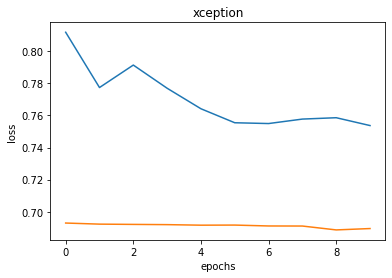

Epoch 1/100
49/49 [==============================] - 31s 532ms/step - loss: 0.7418 - accuracy: 0.5551 - val_loss: 0.6929 - val_accuracy: 0.5175
Epoch 2/100
49/49 [==============================] - 25s 512ms/step - loss: 0.6922 - accuracy: 0.5851 - val_loss: 0.6933 - val_accuracy: 0.5175
Epoch 3/100
49/49 [==============================] - 25s 510ms/step - loss: 0.6532 - accuracy: 0.6076 - val_loss: 0.6952 - val_accuracy: 0.5175
Epoch 4/100
49/49 [==============================] - 25s 510ms/step - loss: 0.5958 - accuracy: 0.6697 - val_loss: 0.6975 - val_accuracy: 0.5175
Epoch 5/100
49/49 [==============================] - 25s 503ms/step - loss: 0.5713 - accuracy: 0.6933 - val_loss: 0.7013 - val_accuracy: 0.5175
Epoch 6/100
49/49 [==============================] - 25s 507ms/step - loss: 0.5221 - accuracy: 0.7458 - val_loss: 0.7083 - val_accuracy: 0.5175

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
Epoch 7/100
49/49 [==============================] - 25

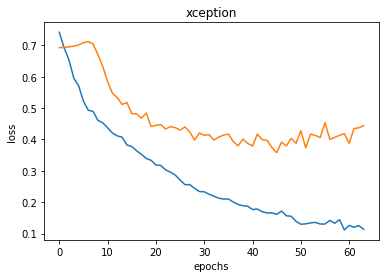

87924736/87910968 [==============================] - 0s 0us/step
Found 1574 non-validated image filenames belonging to 2 classes.
Found 400 non-validated image filenames belonging to 2 classes.
Found 23064 non-validated image filenames belonging to 2 classes.
Epoch 1/10
50/50 [==============================] - 37s 653ms/step - loss: 0.9319 - accuracy: 0.5051 - val_loss: 0.6926 - val_accuracy: 0.5425
Epoch 2/10
50/50 [==============================] - 18s 353ms/step - loss: 0.8797 - accuracy: 0.5076 - val_loss: 0.6874 - val_accuracy: 0.5275
Epoch 3/10
50/50 [==============================] - 17s 341ms/step - loss: 0.8509 - accuracy: 0.4930 - val_loss: 0.6865 - val_accuracy: 0.5250
Epoch 4/10
50/50 [==============================] - 18s 356ms/step - loss: 0.7936 - accuracy: 0.5197 - val_loss: 0.7073 - val_accuracy: 0.5225
Epoch 5/10
50/50 [==============================] - 17s 341ms/step - loss: 0.7819 - accuracy: 0.5330 - val_loss: 0.7063 - val_accuracy: 0.5200
Epoch 6/10
50/50 [=======

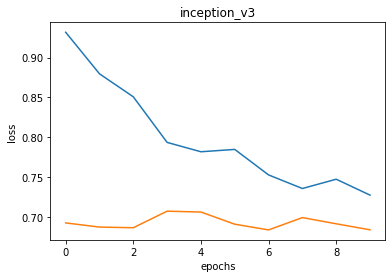

Epoch 1/100
50/50 [==============================] - 28s 431ms/step - loss: 0.7429 - accuracy: 0.5496 - val_loss: 0.7889 - val_accuracy: 0.5100
Epoch 2/100
50/50 [==============================] - 20s 402ms/step - loss: 0.6816 - accuracy: 0.5921 - val_loss: 0.7007 - val_accuracy: 0.4725
Epoch 3/100
50/50 [==============================] - 20s 395ms/step - loss: 0.6393 - accuracy: 0.6334 - val_loss: 0.6968 - val_accuracy: 0.5225
Epoch 4/100
50/50 [==============================] - 20s 400ms/step - loss: 0.5816 - accuracy: 0.6982 - val_loss: 0.8135 - val_accuracy: 0.5175
Epoch 5/100
50/50 [==============================] - 20s 397ms/step - loss: 0.5496 - accuracy: 0.7147 - val_loss: 0.7983 - val_accuracy: 0.4725
Epoch 6/100
50/50 [==============================] - 20s 393ms/step - loss: 0.5253 - accuracy: 0.7306 - val_loss: 0.7173 - val_accuracy: 0.5225
Epoch 7/100
50/50 [==============================] - 20s 394ms/step - loss: 0.5105 - accuracy: 0.7497 - val_loss: 0.7352 - val_accuracy:

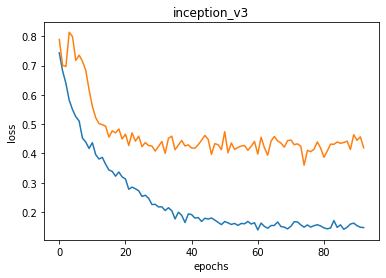

94781440/94765736 [==============================] - 2s 0us/step
Found 1571 non-validated image filenames belonging to 2 classes.
Found 400 non-validated image filenames belonging to 2 classes.
Found 23077 non-validated image filenames belonging to 2 classes.
Epoch 1/10
50/50 [==============================] - 36s 650ms/step - loss: 0.8173 - accuracy: 0.4838 - val_loss: 0.7078 - val_accuracy: 0.5350
Epoch 2/10
50/50 [==============================] - 18s 365ms/step - loss: 0.8023 - accuracy: 0.5118 - val_loss: 0.6783 - val_accuracy: 0.5900
Epoch 3/10
50/50 [==============================] - 18s 364ms/step - loss: 0.7971 - accuracy: 0.4971 - val_loss: 0.6801 - val_accuracy: 0.5925
Epoch 4/10
50/50 [==============================] - 18s 355ms/step - loss: 0.7896 - accuracy: 0.5054 - val_loss: 0.6758 - val_accuracy: 0.6175
Epoch 5/10
50/50 [==============================] - 19s 373ms/step - loss: 0.7630 - accuracy: 0.5226 - val_loss: 0.6715 - val_accuracy: 0.6000
Epoch 6/10
50/50 [=======

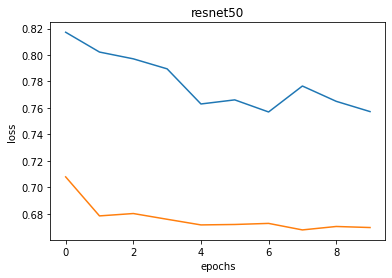

Epoch 1/100
50/50 [==============================] - 29s 458ms/step - loss: 0.7243 - accuracy: 0.5582 - val_loss: 0.7909 - val_accuracy: 0.5350
Epoch 2/100
50/50 [==============================] - 21s 424ms/step - loss: 0.6481 - accuracy: 0.6289 - val_loss: 0.8235 - val_accuracy: 0.5350
Epoch 3/100
50/50 [==============================] - 21s 430ms/step - loss: 0.6019 - accuracy: 0.6830 - val_loss: 0.8259 - val_accuracy: 0.5350
Epoch 4/100
50/50 [==============================] - 22s 431ms/step - loss: 0.5217 - accuracy: 0.7403 - val_loss: 0.8307 - val_accuracy: 0.5350
Epoch 5/100
50/50 [==============================] - 21s 423ms/step - loss: 0.4924 - accuracy: 0.7804 - val_loss: 0.8545 - val_accuracy: 0.5350
Epoch 6/100
50/50 [==============================] - 22s 436ms/step - loss: 0.4375 - accuracy: 0.8180 - val_loss: 0.8974 - val_accuracy: 0.5350

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
Epoch 7/100
50/50 [==============================] - 22

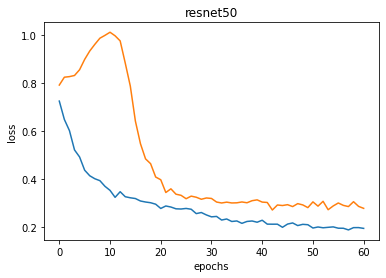

219070464/219055592 [==============================] - 1s 0us/step
Found 1546 non-validated image filenames belonging to 2 classes.
Found 400 non-validated image filenames belonging to 2 classes.
Found 23082 non-validated image filenames belonging to 2 classes.
Epoch 1/10
49/49 [==============================] - 43s 685ms/step - loss: 0.8456 - accuracy: 0.4994 - val_loss: 0.6988 - val_accuracy: 0.5275
Epoch 2/10
49/49 [==============================] - 19s 394ms/step - loss: 0.8113 - accuracy: 0.5013 - val_loss: 0.6957 - val_accuracy: 0.5275
Epoch 3/10
49/49 [==============================] - 19s 391ms/step - loss: 0.8032 - accuracy: 0.4748 - val_loss: 0.6947 - val_accuracy: 0.5275
Epoch 4/10
49/49 [==============================] - 19s 384ms/step - loss: 0.7849 - accuracy: 0.4948 - val_loss: 0.6921 - val_accuracy: 0.5275
Epoch 5/10
49/49 [==============================] - 19s 389ms/step - loss: 0.7951 - accuracy: 0.4961 - val_loss: 0.6916 - val_accuracy: 0.5275
Epoch 6/10
49/49 [=====

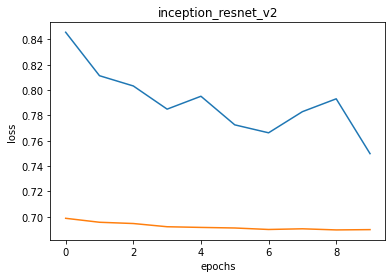

Epoch 1/100
49/49 [==============================] - 45s 577ms/step - loss: 0.7697 - accuracy: 0.5201 - val_loss: 0.6962 - val_accuracy: 0.5275
Epoch 2/100
49/49 [==============================] - 24s 490ms/step - loss: 0.7091 - accuracy: 0.5602 - val_loss: 0.8141 - val_accuracy: 0.4600
Epoch 3/100
49/49 [==============================] - 24s 486ms/step - loss: 0.6786 - accuracy: 0.6003 - val_loss: 0.9098 - val_accuracy: 0.4600
Epoch 4/100
49/49 [==============================] - 24s 491ms/step - loss: 0.6039 - accuracy: 0.6688 - val_loss: 2.5656 - val_accuracy: 0.4575
Epoch 5/100
49/49 [==============================] - 24s 489ms/step - loss: 0.5851 - accuracy: 0.6785 - val_loss: 5.4779 - val_accuracy: 0.4200
Epoch 6/100
49/49 [==============================] - 24s 489ms/step - loss: 0.5403 - accuracy: 0.7296 - val_loss: 5.9629 - val_accuracy: 0.4450

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
Epoch 7/100
49/49 [==============================] - 24

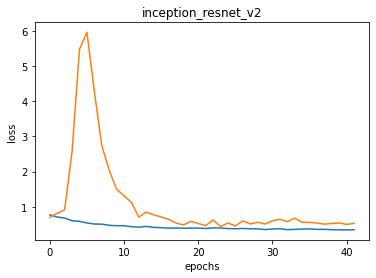

In [6]:
trained_models = {}
for model_name in list(models.keys()):
    trained_models[model_name] = make_train_model(model_name)

Found 10920 non-validated image filenames belonging to 2 classes.
Found 4400 non-validated image filenames belonging to 2 classes.
Found 10356 non-validated image filenames belonging to 2 classes.
Epoch 1/10
342/342 [==============================] - 226s 654ms/step - loss: 0.7641 - accuracy: 0.5146 - val_loss: 0.6884 - val_accuracy: 0.5486
Epoch 2/10
342/342 [==============================] - 134s 393ms/step - loss: 0.7426 - accuracy: 0.5256 - val_loss: 0.6937 - val_accuracy: 0.5409
Epoch 3/10
342/342 [==============================] - 134s 393ms/step - loss: 0.7260 - accuracy: 0.5351 - val_loss: 0.6909 - val_accuracy: 0.5489
Epoch 4/10
342/342 [==============================] - 134s 392ms/step - loss: 0.7260 - accuracy: 0.5355 - val_loss: 0.6841 - val_accuracy: 0.5611
Epoch 5/10
342/342 [==============================] - 135s 395ms/step - loss: 0.7109 - accuracy: 0.5457 - val_loss: 0.6825 - val_accuracy: 0.5607
Epoch 6/10
342/342 [==============================] - 136s 397ms/step - l

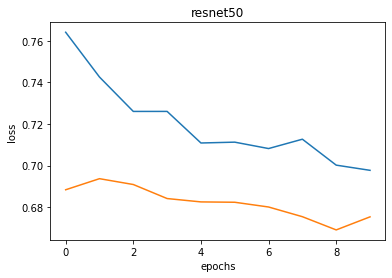

Epoch 1/100
342/342 [==============================] - 162s 459ms/step - loss: 0.4580 - accuracy: 0.7995 - val_loss: 0.9069 - val_accuracy: 0.4939
Epoch 2/100
342/342 [==============================] - 156s 456ms/step - loss: 0.2488 - accuracy: 0.9342 - val_loss: 0.8635 - val_accuracy: 0.5286
Epoch 3/100
342/342 [==============================] - 155s 452ms/step - loss: 0.1793 - accuracy: 0.9555 - val_loss: 0.3657 - val_accuracy: 0.8284
Epoch 4/100
342/342 [==============================] - 155s 454ms/step - loss: 0.1409 - accuracy: 0.9656 - val_loss: 0.2873 - val_accuracy: 0.8750
Epoch 5/100
342/342 [==============================] - 157s 460ms/step - loss: 0.1168 - accuracy: 0.9721 - val_loss: 0.2848 - val_accuracy: 0.8811
Epoch 6/100
342/342 [==============================] - 156s 456ms/step - loss: 0.0981 - accuracy: 0.9781 - val_loss: 0.2713 - val_accuracy: 0.8902
Epoch 7/100
342/342 [==============================] - 156s 457ms/step - loss: 0.0848 - accuracy: 0.9822 - val_loss: 0

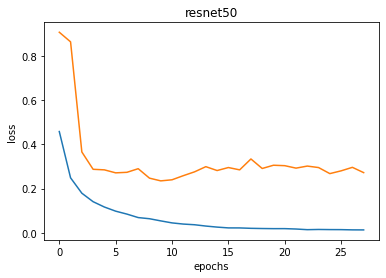

In [7]:
final_model,final_history_pre,final_history = make_train_model("resnet50",train_size = 22000)

Found 11001 non-validated image filenames belonging to 2 classes.
Found 4400 non-validated image filenames belonging to 2 classes.
Found 10345 non-validated image filenames belonging to 2 classes.
Epoch 1/10
114/344 [========>.....................] - ETA: 1:36 - loss: 0.8220 - accuracy: 0.5151

/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


344/344 [==============================] - 193s 531ms/step - loss: 0.7887 - accuracy: 0.5107 - val_loss: 0.6906 - val_accuracy: 0.5275
Epoch 2/10
344/344 [==============================] - 143s 416ms/step - loss: 0.7672 - accuracy: 0.5060 - val_loss: 0.6897 - val_accuracy: 0.5391
Epoch 3/10
344/344 [==============================] - 145s 423ms/step - loss: 0.7595 - accuracy: 0.5013 - val_loss: 0.6922 - val_accuracy: 0.5214
Epoch 4/10
344/344 [==============================] - 142s 412ms/step - loss: 0.7421 - accuracy: 0.5140 - val_loss: 0.6913 - val_accuracy: 0.5220
Epoch 5/10
344/344 [==============================] - 143s 415ms/step - loss: 0.7421 - accuracy: 0.5084 - val_loss: 0.6903 - val_accuracy: 0.5286
Epoch 6/10
344/344 [==============================] - 143s 415ms/step - loss: 0.7386 - accuracy: 0.5046 - val_loss: 0.6892 - val_accuracy: 0.5375
Epoch 7/10
344/344 [==============================] - 142s 412ms/step - loss: 0.7333 - accuracy: 0.5095 - val_loss: 0.6886 - val_accura

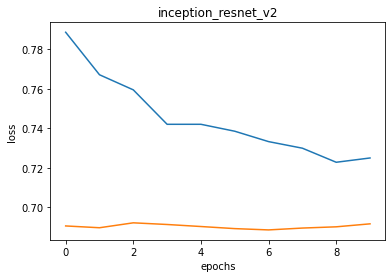

Epoch 1/100
344/344 [==============================] - 198s 526ms/step - loss: 0.6113 - accuracy: 0.6621 - val_loss: 1.4656 - val_accuracy: 0.4750
Epoch 2/100
344/344 [==============================] - 177s 513ms/step - loss: 0.3948 - accuracy: 0.8404 - val_loss: 0.5370 - val_accuracy: 0.8070
Epoch 3/100
344/344 [==============================] - 177s 515ms/step - loss: 0.2700 - accuracy: 0.9055 - val_loss: 0.4507 - val_accuracy: 0.8505
Epoch 4/100
344/344 [==============================] - 176s 513ms/step - loss: 0.2063 - accuracy: 0.9349 - val_loss: 0.3828 - val_accuracy: 0.8582
Epoch 5/100
344/344 [==============================] - 176s 512ms/step - loss: 0.1741 - accuracy: 0.9446 - val_loss: 0.4305 - val_accuracy: 0.8693
Epoch 6/100
344/344 [==============================] - 177s 514ms/step - loss: 0.1479 - accuracy: 0.9526 - val_loss: 0.4167 - val_accuracy: 0.8743
Epoch 7/100
344/344 [==============================] - 176s 512ms/step - loss: 0.1273 - accuracy: 0.9607 - val_loss: 0

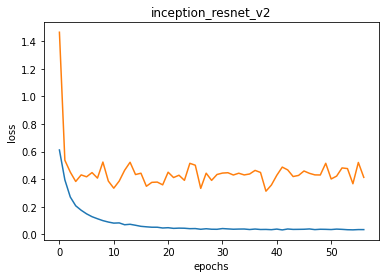

In [8]:
final_model2,final_history_pre2,final_history2 = make_train_model("inception_resnet_v2",train_size = 22000)